<a href="https://colab.research.google.com/github/joris-vaneyghen/mss-jazz-playalong/blob/main/segmentation/cluster_segments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# download our audio example
!git clone https://github.com/joris-vaneyghen/mss-jazz-playalong.git

Cloning into 'mss-jazz-playalong'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 199 (delta 103), reused 158 (delta 80), pack-reused 7 (from 1)
Receiving objects: 100% (199/199), 42.26 MiB | 12.29 MiB/s, done.
Resolving deltas: 100% (103/103), done.
Updating files: 100% (23/23), done.


In [7]:
import numpy as np
import json
import os

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.covariance import EllipticEnvelope

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from scipy.stats import multivariate_normal
from scipy.stats import chi2
from scipy.spatial.distance import mahalanobis

import matplotlib.pyplot as plt

from tqdm import tqdm

In [8]:
with open('mss-jazz-playalong/sound_classes_audioset.json', 'r') as f:
  sound_classes_audioset = json.load(f)

In [9]:
input_path = 'mss-jazz-playalong/examples'
output_path = 'mss-jazz-playalong/out/segment_and_tag'
resolution = 0.32 # resolution of EfficientAT model

In [10]:
def load_json(dir, mp3_file):
    # Replace .mp3 extension with .json
    json_file_name = mp3_file.replace('.mp3', '.json')
    file_path = os.path.join(dir, json_file_name)

    # Check if the .json file exists
    if not os.path.exists(file_path):
        return {}  # Return an empty dictionary if the .json file doesn't exist

    # Load the JSON file if it exists
    with open(file_path, 'r') as file:
        return json.load(file)

# def save_json(dir, mp3_file, data):
#     # Replace .mp3 extension with .json
#     json_file_name = mp3_file.replace('.mp3', '.json')
#     file_path = os.path.join(dir, json_file_name)

#     # Check if directory exists, create it if not
#     if not os.path.exists(dir):
#         os.makedirs(dir)

#     # Save the data to the .json file
#     with open(file_path, 'w') as file:
#         json.dump(data, file, indent=4)

def iterate_files(dir):
    for file_name in os.listdir(dir):
        if file_name.endswith('.mp3'):
            yield file_name


def calc_features(segment_preds, drums, bass, vocals):
  segment_preds = np.array(segment_preds)
  features = []
  for audio_class in sound_classes_audioset:
    if audio_class == 'drums':
      features.append(drums)
    elif audio_class == 'bass':
      features.append(bass)
    elif audio_class == 'vocals':
      features.append(vocals)
    else:
      audioset_indices = [ audio_set_cls['index'] for audio_set_cls in sound_classes_audioset[audio_class]]
      features.append(segment_preds[audioset_indices].sum(axis=0))

  # return np.array(features)
  return np.stack(features, axis=0)


In [12]:
def load_all_data():
  features = []
  segment_lengths = []

  for mp3_file in tqdm(iterate_files(input_path)):
    data = load_json(output_path, mp3_file)
    if ('demucs' in data.keys() and 'segments' in data.keys()):
      segments = data['segments']
      for segment in segments:
        length = segment['end_idx'] - segment['start_idx']
        segment_lengths.append(length)
        features.append(calc_features(segment['preds'], segment['drums'], segment['bass'], segment['vocals']))

  features = np.stack(features, axis=0)
  return features

In [13]:
data = load_all_data()
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data)

3it [00:00,  7.37it/s]


In [14]:
X = data
model = EllipticEnvelope(contamination=0.10, random_state=42, assume_centered= True)
model.fit(X)
y_pred = model.predict(X)
nb_inliers = np.count_nonzero(y_pred == 1)
nb_outliers = np.count_nonzero(y_pred == -1)
print(f"Number of inliers: {nb_inliers}")
print(f"Number of outliers: {nb_outliers}")

Number of inliers: 194
Number of outliers: 22


In [15]:
def remove_outliers(data):
  contamination_values = np.linspace(0.05, 0.50, 10)
  sub_size = 2000
  error_threshold = 1.15
  sub_data = data[0:min(sub_size, data.shape[0]),:]
  best_contamination = 0.5
  X = sub_data
  for contamination in contamination_values:
    elliptic_env = EllipticEnvelope(contamination=contamination, random_state=42, assume_centered= True)
    elliptic_env.fit(X)
    y_pred = elliptic_env.predict(X)
    n_components = 1  # Reduceer naar 1 component
    pca = PCA(n_components=n_components)
    X_IN = X[y_pred == 1]
    X_IN_pca = pca.fit_transform(X_IN)
    X_IN_reconstructed = pca.inverse_transform(X_IN_pca)
    reconstruction_error_IN = np.linalg.norm(X_IN - X_IN_reconstructed, axis=1)
    mean_error_inliers = np.mean(reconstruction_error_IN)
    if mean_error_inliers < error_threshold:
      best_contamination = contamination
      break

  contamination_values = np.linspace(best_contamination - 0.04, best_contamination, 5)
  best_contamination = 0.5
  X = data
  for contamination in contamination_values:
    elliptic_env = EllipticEnvelope(contamination=contamination, random_state=42, assume_centered= True)
    elliptic_env.fit(X)
    y_pred = elliptic_env.predict(X)
    n_components = 1  # Reduceer naar 1 component
    pca = PCA(n_components=n_components)
    X_IN = X[y_pred == 1]
    X_IN_pca = pca.fit_transform(X_IN)
    X_IN_reconstructed = pca.inverse_transform(X_IN_pca)
    reconstruction_error_IN = np.linalg.norm(X_IN - X_IN_reconstructed, axis=1)
    mean_error_inliers = np.mean(reconstruction_error_IN)
    if mean_error_inliers < error_threshold:
      best_contamination = contamination
      break

  return X_IN , X[y_pred == -1]


  print(f"Best contamination value: {best_contamination}")
  print(f"Mean error inliers: {mean_error_inliers}")


In [16]:
def split_inside_outside(mean, covariance, data, quantile=0.95):


  # Inverse of the covariance matrix for Mahalanobis distance calculation
  cov_inv = np.linalg.inv(covariance)

  # Calculate the Mahalanobis distance for each point
  mahalanobis_distances = np.array([mahalanobis(x, mean, cov_inv) for x in data])

  # Find the 95% quantile for the chi-squared distribution with 'n_features' degrees of freedom
  threshold = chi2.ppf(0.95, df=mean.shape[0])
  # print(f"Chi-squared threshold for 95% confidence: {np.sqrt(threshold)}")

  # Select points where the Mahalanobis distance is less than or equal to the threshold
  sqrt_threshold = np.sqrt(threshold)
  inside_95_percent = data[mahalanobis_distances <= sqrt_threshold]
  outside_95_percent = data[mahalanobis_distances > sqrt_threshold]

  print("Data inside the 95% border:", inside_95_percent.shape[0])
  print("Data outside the 95% border:", outside_95_percent.shape[0])
  return inside_95_percent, outside_95_percent

In [17]:
data_clean, data_error = remove_outliers(data)
data_clean.shape, data_error.shape

((213, 12), (3, 12))

In [19]:
# Create a multivariate normal distribution object
mean = np.mean(data_clean, axis=0)
covariance = np.cov(data_clean, rowvar=False)
# mvn = multivariate_normal(mean=mean, cov=covariance)


# cdf_value = mvn.pdf(data_error)
# cdf_value, mvn.pdf(data_clean)

In [20]:
data_in, data_out = split_inside_outside(mean=mean, covariance=covariance, data=data_clean)

Data inside the 95% border: 183
Data outside the 95% border: 30


In [30]:
model = {'scaler' : scaler}
model['drums,piano'] = {'mean' : mean, 'covariance' : covariance}

In [22]:
#save  model to file

import pickle

# Save the model to a file
with open('my_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [23]:
# load file my_model.pkl to model

with open('my_model.pkl', 'rb') as f:
    model = pickle.load(f)

array([[0.00334979, 0.00967645, 0.04070609, ..., 0.18921354, 0.14382845,
        0.06273875],
       [0.00333683, 0.00977191, 0.04072386, ..., 0.18917088, 0.14344328,
        0.06274306],
       [0.00333306, 0.00958013, 0.04126279, ..., 0.19281972, 0.15285623,
        0.06305396],
       ...,
       [0.00358098, 0.01021758, 0.04079529, ..., 0.19164785, 0.14557174,
        0.06478101],
       [0.00346303, 0.01013843, 0.04198583, ..., 0.18985915, 0.14537426,
        0.06303927],
       [0.00362939, 0.00989324, 0.04170675, ..., 0.18970027, 0.14371969,
        0.06284225]])

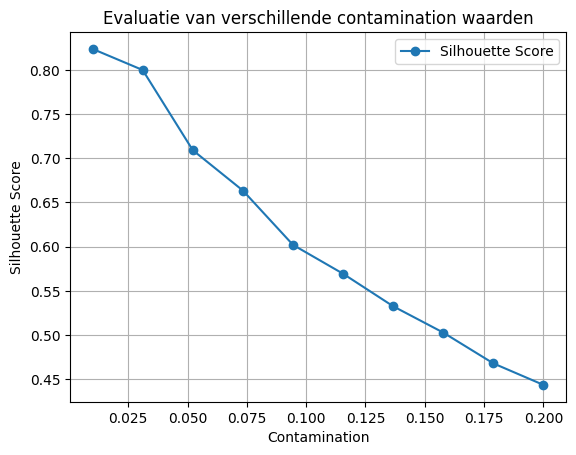

Beste contamination waarde: 0.01, Silhouette Score: 0.8237614106708939


In [ ]:
# 2. Definieer een lijst van mogelijke contamination waarden
contamination_values = np.linspace(0.01, 0.2, 10)

# Lijsten om de resultaten op te slaan
best_score = -1
best_contamination = None
scores = []

# 3. Voor elke contamination-waarde, train een Elliptic Envelope model
for contamination in contamination_values:
    model = EllipticEnvelope(contamination=contamination, random_state=42)
    model.fit(X)

    # Voorspel de outliers (-1) en inliers (1)
    y_pred = model.predict(X)

    # Bereken de Silhouette Score (alleen zinvol als beide klassen aanwezig zijn)
    if len(set(y_pred)) > 1:
        score = silhouette_score(X, y_pred)
        scores.append(score)

        # Update de beste score en contamination
        if score > best_score:
            best_score = score
            best_contamination = contamination

# 4. Visualiseer de scores voor verschillende contamination waarden
plt.plot(contamination_values[:len(scores)], scores, marker='o', label='Silhouette Score')
plt.xlabel('Contamination')
plt.ylabel('Silhouette Score')
plt.title('Evaluatie van verschillende contamination waarden')
plt.grid(True)
plt.legend()
plt.show()

print(f"Beste contamination waarde: {best_contamination}, Silhouette Score: {best_score}")


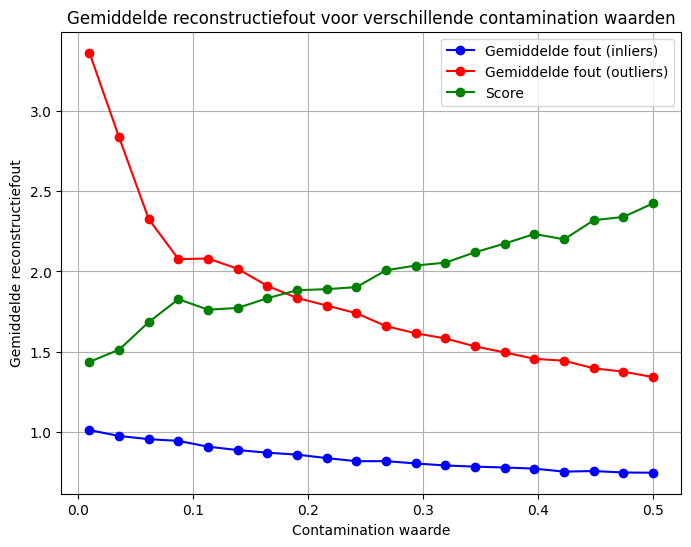

In [ ]:
# Lijsten om de resultaten op te slaan
mean_errors_inliers = []
mean_errors_outliers = []
scores = []

alpha=1.0
epsilon=1e-6

contamination_values = np.linspace(0.01, 0.5, 20)
# 3. Loop door verschillende contamination waarden
for contamination in contamination_values:
    # Train het Elliptic Envelope model
    elliptic_env = EllipticEnvelope(contamination=contamination, random_state=42)
    elliptic_env.fit(X)
    y_pred = elliptic_env.predict(X)

    # Voer PCA uit om de data te reduceren naar een lager aantal dimensies (bijv. 1D)
    n_components = 1  # Reduceer naar 1 component
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Reconstructeer de data met PCA
    X_reconstructed = pca.inverse_transform(X_pca)

    # Bereken de reconstructiefout (Euclidische afstand)
    reconstruction_error = np.linalg.norm(X - X_reconstructed, axis=1)

    # Bereken gemiddelde reconstructiefout voor inliers en outliers
    mean_error_inliers = np.mean(reconstruction_error[y_pred == 1])
    mean_error_outliers = np.mean(reconstruction_error[y_pred == -1])

    # Voeg de gemiddelde fouten toe aan de lijsten
    mean_errors_inliers.append(mean_error_inliers)
    mean_errors_outliers.append(mean_error_outliers)
    score = mean_error_inliers + alpha * (1 / (mean_error_outliers - mean_error_inliers + epsilon))
    scores.append(score)





# 4. Plot de gemiddelde reconstructiefout voor verschillende contamination waarden
plt.figure(figsize=(8, 6))
plt.plot(contamination_values, mean_errors_inliers, marker='o', color='blue', label='Gemiddelde fout (inliers)')
plt.plot(contamination_values, mean_errors_outliers, marker='o', color='red', label='Gemiddelde fout (outliers)')
plt.plot(contamination_values, scores, marker='o', color='green', label='Score')
plt.xlabel('Contamination waarde')
plt.ylabel('Gemiddelde reconstructiefout')
plt.title('Gemiddelde reconstructiefout voor verschillende contamination waarden')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# # plot frequency chart of segment_lengths
# plt.hist(segment_lengths, bins=20)
# plt.xlabel("Segment Length")
# plt.ylabel("Frequency")
# plt.title("Frequency Chart of Segment Lengths")
# plt.show()


In [ ]:
# segment_preds = np.array(segment_preds)
# drums = np.array(drums)
# bass = np.array(bass)
# other = np.array(other)
# vocals = np.array(vocals)
# demucs_features = np.stack((drums, bass, vocals, other), axis=1)

In [ ]:
# features = calc_features(segment_preds, drums, bass, vocals);
# features.shape

In [ ]:

scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)
from sklearn.preprocessing import minmax_scale
features_normalized = minmax_scale(features, axis=0)

In [ ]:
def find_best_cluster(data):
  eps_range = np.arange(0.1, 10, 0.1)  # Example range of epsilon values
  min_samples = data.shape[0] // 100

  best_silhouette_score = -1
  silhouette_scores = []
  nb_labels = []
  nb_noise = []
  best_eps = None
  best_labels = None

  for eps in eps_range:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)



    unique_labels, label_counts = np.unique(labels, return_counts=True)
    best_label = unique_labels[np.argmax(label_counts)]

    # Ignore noisy samples (-1) for silhouette calculation
    if len(np.unique(labels)) > 2 and best_label != -1:
      data_without_noise = data[labels != -1]
      labels_without_noise = labels[labels != -1]

      silhouette_avg = silhouette_score(data_without_noise, labels_without_noise, metric='euclidean')
      silhouette_scores.append(silhouette_avg)
      nb_labels.append(len(np.unique(labels)))
      nb_noise.append(np.count_nonzero(labels == -1))

      if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_eps = eps
        best_labels = labels
    else:
      silhouette_scores.append(-1)
      nb_labels.append(-1)
      nb_noise.append(-1)

  print(f"Best epsilon: {best_eps}")
  print(f"Best Silhouette Score: {best_silhouette_score}")

  # Perform DBSCAN clustering with the best parameters
  dbscan = DBSCAN(eps=best_eps, min_samples=min_samples)
  labels = dbscan.fit_predict(data)

  # Print cluster labels for each sample
  print("Cluster labels for the data points:", labels)

  unique_labels, label_counts = np.unique(labels, return_counts=True)
  best_label = unique_labels[np.argmax(label_counts)]
  print(f"Cluster label with max count: {best_label}")

  # Plot the frequencies of labels
  plt.bar(unique_labels, label_counts)
  plt.xlabel('Cluster Labels')
  plt.ylabel('Frequency')
  plt.title('Frequency of Cluster Labels')
  plt.show()

  # Plot Silhouette Score for each k
  plt.figure(figsize=(10, 5))
  plt.plot(eps_range, silhouette_scores, 'bx-')
  plt.xlabel('eps')
  plt.ylabel('Silhouette Score')
  plt.title('Silhouette Score for Different eps')
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot(eps_range, nb_labels, 'bx-')
  plt.xlabel('eps')
  plt.ylabel('Nb labels')
  plt.title('Nb labels for Different eps')
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot(eps_range, nb_noise, 'bx-')
  plt.xlabel('eps')
  plt.ylabel('Nb noise')
  plt.title('Nb noise for Different eps')
  plt.show()

  indexes_best_cluster = np.where(labels == best_label)[0]


  return indexes_best_cluster



Best epsilon: 6.0
Best Silhouette Score: 0.7338154507426868
Cluster labels for the data points: [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  0 -1  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Cluster label with max count: 0


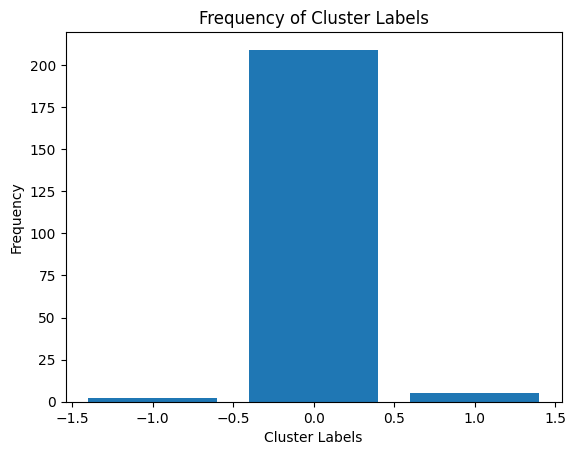

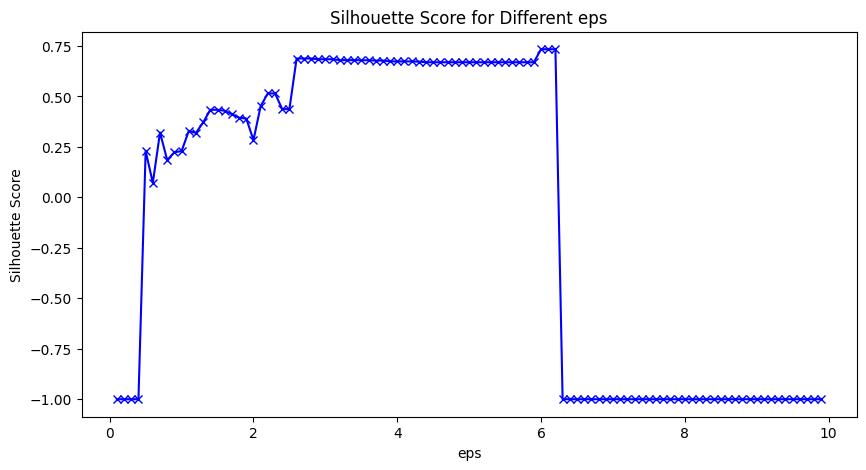

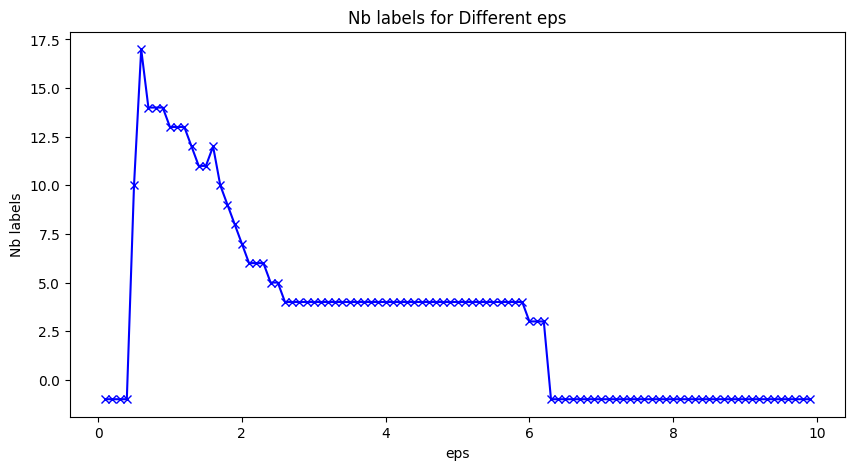

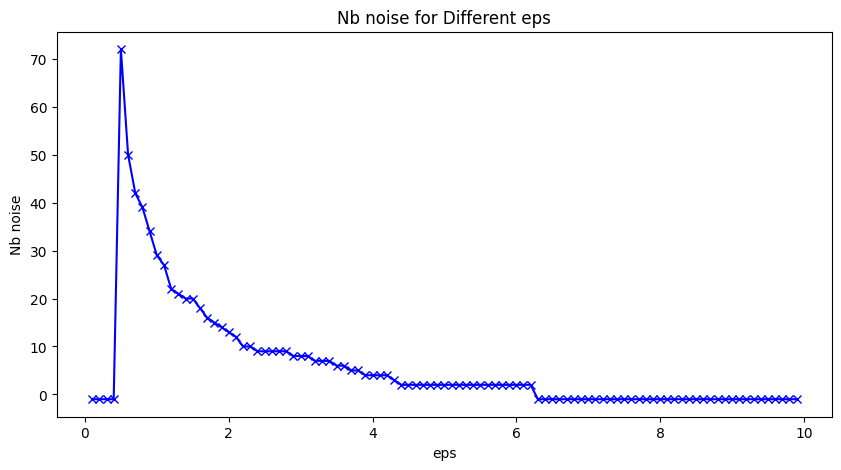

In [ ]:
indexes_best_cluster = find_best_cluster(normalized_features)
# indexes_best_cluster
features_best_cluster = features[indexes_best_cluster]
features_non_best_cluster = features[~np.isin(np.arange(features.shape[0]), indexes_best_cluster)]

In [ ]:
from sklearn.mixture import GaussianMixture
from scipy.stats import chi2


In [ ]:
n_components = 8
gmm = GaussianMixture(n_components=n_components, covariance_type='full')
gmm.fit(features_normalized)


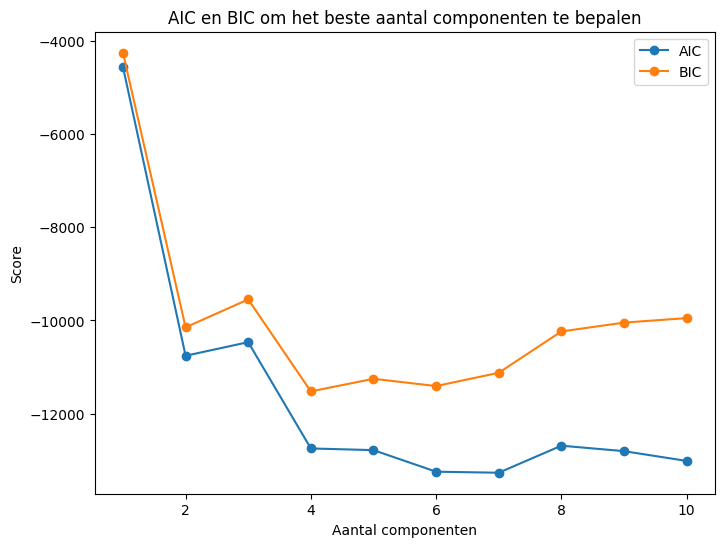

In [ ]:
X = features_normalized
# Test verschillende aantallen componenten
n_components_range = range(1, 11)  # Test van 1 tot 10 componenten
aic_scores = []
bic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X)

    # Voeg AIC en BIC toe aan de lijsten
    aic_scores.append(gmm.aic(X))
    bic_scores.append(gmm.bic(X))

# Plot de AIC en BIC scores
plt.figure(figsize=(8, 6))
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.xlabel('Aantal componenten')
plt.ylabel('Score')
plt.title('AIC en BIC om het beste aantal componenten te bepalen')
plt.legend()
plt.show()


In [ ]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
gmm.fit(features_normalized)

GaussianMixture(n_components=4, random_state=42)

In [ ]:

import numpy as np

for i in range(gmm.weights_.shape[0]):
  print(f"Component {i+1}:")
  print(f"  Weight: {gmm.weights_[i]:.2f}")
  for j, audio_class in enumerate(sound_classes_audioset):
    print(f"    {audio_class}: {gmm.means_[i][j]:.2f}")


Component 1:
  Weight: 0.17
    drums: 0.03
    bass: 0.03
    piano: 0.09
    guitar: 0.04
    wind_instrument: 0.19
    bowed_string_instrument: 0.05
    other_instrument: 0.04
    vocals: 0.01
    speech: 0.08
    audience: 0.05
    timekeeping_sound: 0.08
    environmental_noise: 0.03
Component 2:
  Weight: 0.14
    drums: 0.27
    bass: 0.46
    piano: 0.03
    guitar: 0.02
    wind_instrument: 0.12
    bowed_string_instrument: 0.01
    other_instrument: 0.01
    vocals: 0.55
    speech: 0.00
    audience: 0.00
    timekeeping_sound: 0.00
    environmental_noise: 0.00
Component 3:
  Weight: 0.03
    drums: 0.13
    bass: 0.01
    piano: 0.13
    guitar: 0.64
    wind_instrument: 0.71
    bowed_string_instrument: 0.29
    other_instrument: 0.38
    vocals: 0.00
    speech: 0.47
    audience: 0.85
    timekeeping_sound: 0.84
    environmental_noise: 0.33
Component 4:
  Weight: 0.65
    drums: 0.01
    bass: 0.03
    piano: 0.00
    guitar: 0.02
    wind_instrument: 0.18
    bowed_st

In [ ]:
X = features_best_cluster

# log_likelihood = gmm.score_samples(features_best_cluster)


# Bereken de Mahalanobis distance per component
mahalanobis_distances = []
for i in range(gmm.n_components):
    diff = X - gmm.means_[i]
    inv_cov = np.linalg.inv(gmm.covariances_[i])
    mahalanobis_distances.append(np.sum(np.dot(diff, inv_cov) * diff, axis=1))

# Neem de minimale Mahalanobis afstand voor elk punt (dichtstbijzijnde component)
mahalanobis_distance = np.min(mahalanobis_distances, axis=0)

# Chi2 threshold bij 95% confidence voor het aantal dimensies
p_value_threshold = 0.90
chi2_threshold = chi2.ppf(p_value_threshold, df=X.shape[1])

# Tel de punten binnen en buiten de chi2 threshold
nb_in  = np.count_nonzero(mahalanobis_distance <= chi2_threshold)
nb_out = np.count_nonzero(mahalanobis_distance > chi2_threshold)

print(f"Aantal punten binnen de 95% drempel: {nb_in}")
print(f"Aantal punten buiten de 95% drempel: {nb_out}")


Aantal punten binnen de 95% drempel: 195
Aantal punten buiten de 95% drempel: 14


In [ ]:
# Range of clusters to try (from 2 to 5)
cluster_range = range(2, 40)

# List to store SSE (sum of squared distances) for the elbow method
sse = []
silhouette_scores = []


# pca = PCA(n_components=20)  # Reduce to 50 dimensions or fewer


# combined = np.concatenate((segment_preds, demucs_features * 10 ), axis=1)
# data = pca.fit_transform(combined)
data = normalized_features

# Perform KMeans clustering for different values of k
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)  # SSE for elbow method
    silhouette_avg = silhouette_score(data, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot SSE for elbow method
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, sse, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Plot Silhouette Score for each k
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.show()

# Choose the best k based on visual inspection of the elbow and silhouette score
best_k = cluster_range[np.argmax(silhouette_scores)]
print(f"Best number of clusters: {best_k}")

# Perform KMeans clustering with the best k
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(data)

# Print cluster labels for each sample
print("Cluster labels for the data points:", labels)

unique_labels, label_counts = np.unique(labels, return_counts=True)

# Plot the frequencies of labels
plt.bar(unique_labels, label_counts)
plt.xlabel('Cluster Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Cluster Labels')
plt.show()


In [ ]:
# cluster data=normalized_features now with DBSCAN instead of kmeans



# Data is already normalized_features

# Perform DBSCAN clustering with different values of eps and min_samples
eps_range = np.arange(0.1, 10, 0.1)  # Example range of epsilon values
min_samples_range = range(3, 5)  # Example range of min_samples values

best_silhouette_score = -1
best_eps = None
best_min_samples = None
best_labels = None

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data)

        # Ignore noisy samples (-1) for silhouette calculation
        if len(np.unique(labels)) > 1:
            silhouette_avg = silhouette_score(data, labels, metric='euclidean')

            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples
                best_labels = labels

print(f"Best epsilon: {best_eps}")
print(f"Best min_samples: {best_min_samples}")
print(f"Best Silhouette Score: {best_silhouette_score}")

# Perform DBSCAN clustering with the best parameters
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels = dbscan.fit_predict(data)

# Print cluster labels for each sample
print("Cluster labels for the data points:", labels)

unique_labels, label_counts = np.unique(labels, return_counts=True)

# Plot the frequencies of labels
plt.bar(unique_labels, label_counts)
plt.xlabel('Cluster Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Cluster Labels')
plt.show()


In [ ]:
# for each clustercenter print largest dimensions. Use the dimension_names

dimension_names = [audio_class for  audio_class in sound_classes_audioset]

for i, cluster_center in enumerate(kmeans.cluster_centers_):
  top_indices = np.argsort(cluster_center)[::-1]  # Sort in descending order
  print(f"\nCluster {i + 1}: Top Dimensions")
  for j in range(5):  # Print top 5 dimensions
    dimension_index = top_indices[j]
    print(f"  {dimension_names[dimension_index]}: {cluster_center[dimension_index]:.4f}")


In [ ]:
import pickle

# Save the PCA model to a file
def save_pca_model(pca, filename="pca_model.pkl"):
  with open(filename, "wb") as f:
    pickle.dump(pca, f)

# Load the PCA model from a file
def load_pca_model(filename="pca_model.pkl"):
  with open(filename, "rb") as f:
    return pickle.load(f)

# Project new data using the loaded PCA model
def transform_data(pca_model, new_data):
  return pca_model.transform(new_data)

def save_kmeans_model(kmeans, filename="kmeans_model.pkl"):
  with open(filename, "wb") as f:
    pickle.dump(kmeans, f)

# Load the KMeans model from a file
def load_kmeans_model(filename="kmeans_model.pkl"):
  with open(filename, "rb") as f:
    return pickle.load(f)

# Predict cluster labels for new data using the loaded KMeans model
def predict_cluster_labels(kmeans_model, new_data):
  return kmeans_model.predict(new_data)

# Example usage:

# Assuming 'pca' is your trained PCA model
save_pca_model(pca)

# Assuming 'kmeans' is your trained KMeans model
save_kmeans_model(kmeans)

# Later, to load and use the model:
loaded_pca = load_pca_model()

# Later, to load and use the model:
loaded_kmeans = load_kmeans_model()

# Example new data
new_data = np.random.rand(10, 531) # Replace with your actual new data

# Project the new data using the loaded PCA model
transformed_data = transform_data(loaded_pca, new_data)
print(transformed_data.shape)

# Predict the cluster labels for the new data
new_labels = predict_cluster_labels(loaded_kmeans, transformed_data)
print(new_labels)

In [ ]:
# prompt: Z-score normalisatie op mijd data features

from scipy.stats import zscore

# Z-score normalisatie op de 'features' data
zscore_features = zscore(features, axis=0)

print(zscore_features.shape)


(216, 12)
